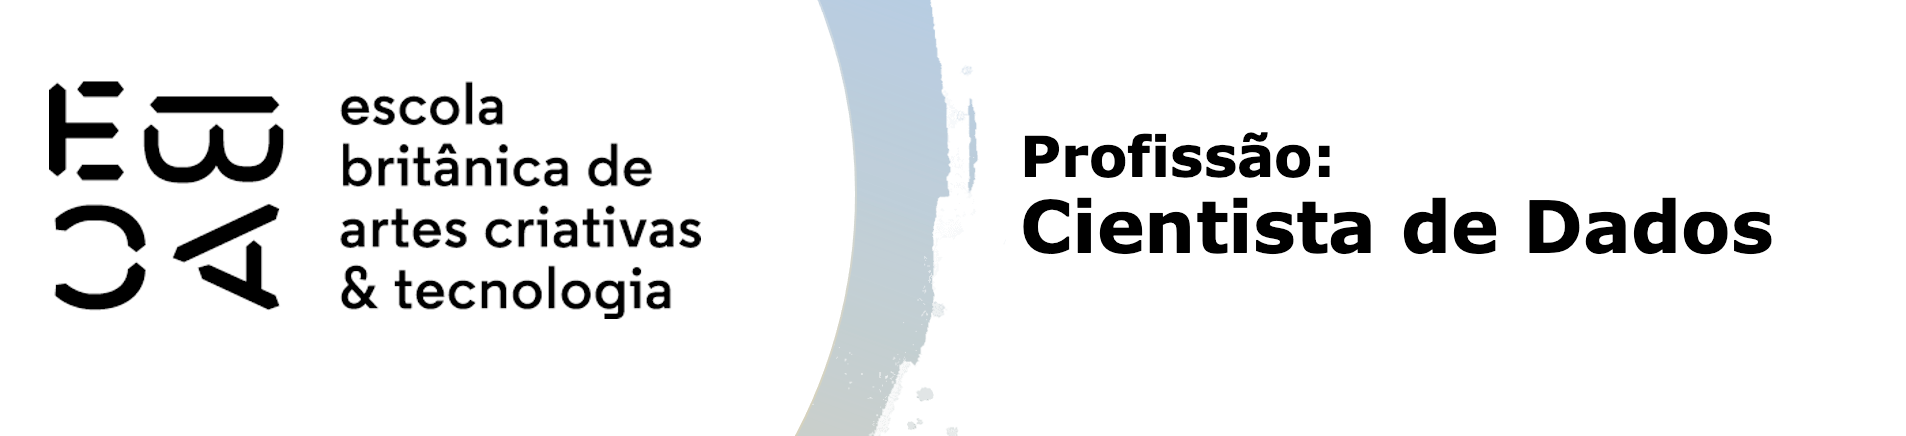

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [13]:
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

df['dia_semana'] = df['Data Emissão'].dt.dayofweek

df['fim_de_semana'] = df['dia_semana'].isin([5, 6]).astype(int)

df['dia_do_mes'] = df['Data Emissão'].dt.day

df['trimestre'] = df['Data Emissão'].dt.quarter

df['valor_5q'] = pd.qcut(df['Valor NF'], 5, labels=False, duplicates='drop')
df['valor_10q'] = pd.qcut(df['Valor NF'], 10, labels=False, duplicates='drop')
df['valor_20q'] = pd.qcut(df['Valor NF'], 20, labels=False, duplicates='drop')
df['valor_50q'] = pd.qcut(df['Valor NF'], 50, labels=False, duplicates='drop')

df['valor_5q'].value_counts().sort_index()

valor_5q
0    37533
1    37526
2    37638
3    37421
4    37528
Name: count, dtype: int64

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [19]:
variaveis = ['dia_semana', 'fim_de_semana', 'dia_do_mes', 'trimestre',
             'valor_5q', 'valor_10q', 'valor_20q', 'valor_50q']
iv_resultados = []

for var in variaveis:
    iv = calcular_iv(df, var)
    iv_resultados.append({'variavel': var, 'IV': iv})

iv_df = pd.DataFrame(iv_resultados).sort_values(by='IV', ascending=False)
print(iv_df)


        variavel        IV
7      valor_50q  0.152315
6      valor_20q  0.124525
5      valor_10q  0.106650
4       valor_5q  0.056695
2     dia_do_mes  0.043719
3      trimestre  0.011507
0     dia_semana  0.006883
1  fim_de_semana  0.004346


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

As variáveis com maior poder de discriminação, segundo o IV, são as categorizações da Valor NF, especialmente com maior número de faixas.
Quanto mais categorias usamos, maior tende a ser o IV — indicando que a granularidade melhora a capacidade preditiva até certo ponto.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

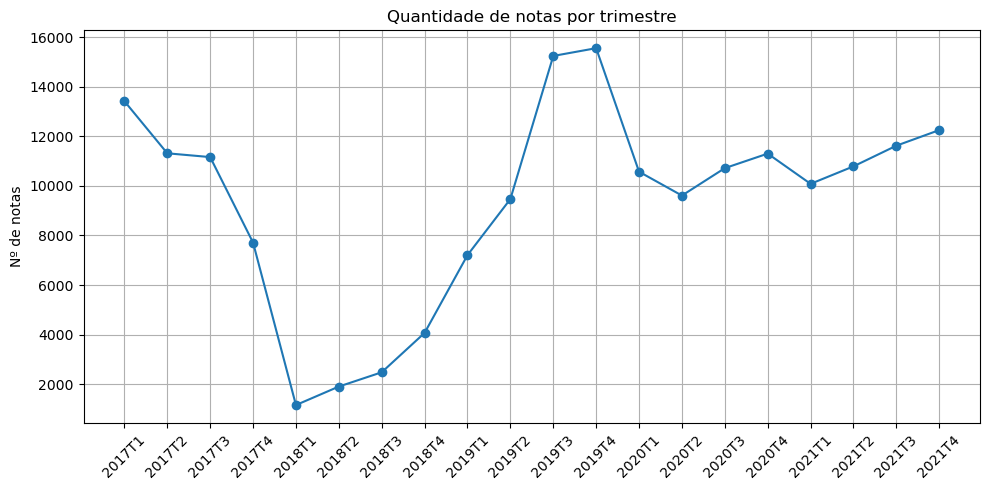

In [21]:
notas_por_trimestre = df.groupby(['Ano', 'trimestre']).size().reset_index(name='qtd_notas')

notas_por_trimestre['periodo'] = notas_por_trimestre['Ano'].astype(str) + 'T' + notas_por_trimestre['trimestre'].astype(str)

plt.figure(figsize=(10, 5))
plt.plot(notas_por_trimestre['periodo'], notas_por_trimestre['qtd_notas'], marker='o')
plt.title('Quantidade de notas por trimestre')
plt.xticks(rotation=45)
plt.ylabel('Nº de notas')
plt.grid(True)
plt.tight_layout()
plt.show()


## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

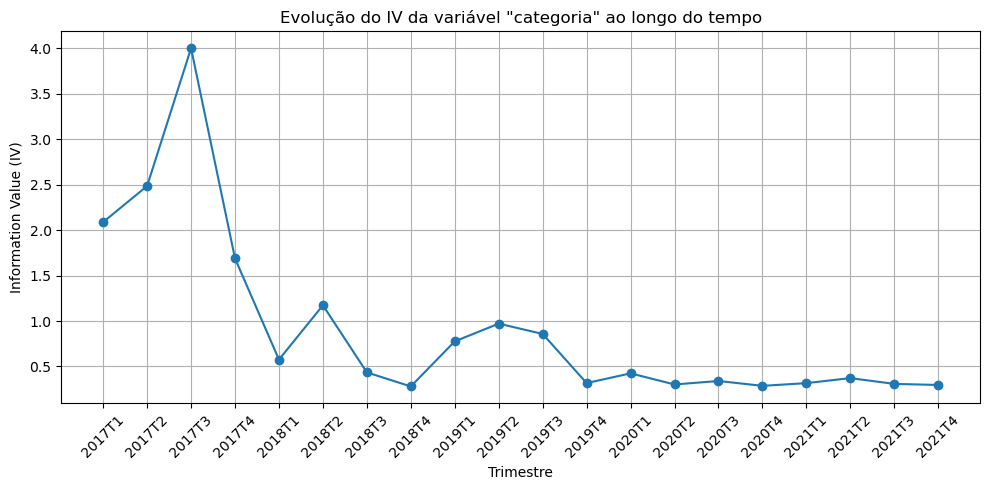

In [25]:
def calcular_woe_iv(df, col, target='flag_credito'):
    df_temp = df[[col, target]].copy()
    total_eventos = df_temp[target].sum()
    total_nao_eventos = len(df_temp) - total_eventos

    grouped = df_temp.groupby(col).agg(
        eventos=(target, 'sum'),
        nao_eventos=(target, lambda x: (1 - x).sum())
    ).reset_index()

    grouped['pct_eventos'] = grouped['eventos'] / total_eventos
    grouped['pct_nao_eventos'] = grouped['nao_eventos'] / total_nao_eventos
    grouped['WOE'] = np.log((grouped['pct_eventos'] + 1e-10) / (grouped['pct_nao_eventos'] + 1e-10))
    grouped['IV'] = (grouped['pct_eventos'] - grouped['pct_nao_eventos']) * grouped['WOE']

    return grouped['IV'].sum()


iv_por_trimestre = []

for (ano, trimestre), grupo in df.groupby(['Ano', 'trimestre']):
    iv = calcular_woe_iv(grupo, 'categoria', target='flag_credito')
    iv_por_trimestre.append({
        'ano': ano,
        'trimestre': trimestre,
        'periodo': f'{ano}T{trimestre}',
        'IV': iv
    })

iv_df = pd.DataFrame(iv_por_trimestre).sort_values('periodo')
plt.figure(figsize=(10, 5))
plt.plot(iv_df['periodo'], iv_df['IV'], marker='o')
plt.title('Evolução do IV da variável "categoria" ao longo do tempo')
plt.xlabel('Trimestre')
plt.ylabel('Information Value (IV)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

Categorias como Restaurantes e Alimentos têm maior proporção de notas com retorno.
A partir de 2020, os padrões se tornam mais estáveis e representativos do público atual.